<a href="https://colab.research.google.com/github/neko88/GoogleCollab/blob/main/Tensorflow_Intro_02_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Following and note-taking the intro tutorial on TensorFlow on [Loading and Preprocessing Images](https://www.tensorflow.org/tutorials/load_data/images#create_a_dataset).

# How to Load and Preprocess an Image Dataset
There are 3 ways:
1. Keras preprocessing utilities
2. Scratch input pipeline
3. Download a dataset from the Tensorflow Datasets

This loads dataset off disk.

# 1) Setup

In [63]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# 2) Download the Flowers Dataset
There are 5 sub-directories of the flower dataset, one per class of flower:
```
flowers_photos/
daisy/
dandelion/
roses/
sunflowers/
tulips/
```



In [64]:
import pathlib

# Obtain the dataset URL
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Get the file from the dataset and save it into a var
archive = tf.keras.utils.get_file(origin=dataset_url , extract=True)

# Make a directory with the path
data_dir = pathlib.Path(archive).with_suffix('')

In [65]:
# Print the number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


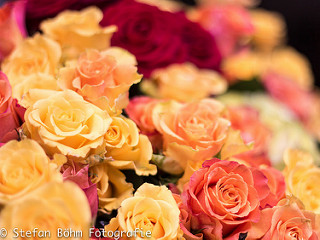

In [66]:
# Print some roses
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

# 3) Load Data using Keras Utility
Load the data off disk using kera's utility.


**Create a Dataset**

Use a validation split when developing a model. 
80% images should be for training while 20% for validation.

In [67]:
# Define parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [68]:
# Make the training dataset from Kera Utility.

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,                               # Directory of the Data
    validation_split = 0.2,                 # Portion of the validation split
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [69]:
# Make the validation dataset from Keras utility.

val_ds = tf.keras.utils.image_dataset_from_directory (
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [70]:
# Find the class names in the class_names attribute on the datasets

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# 4) Visualize the Data
Lets view the first 9 images from the training dataset.

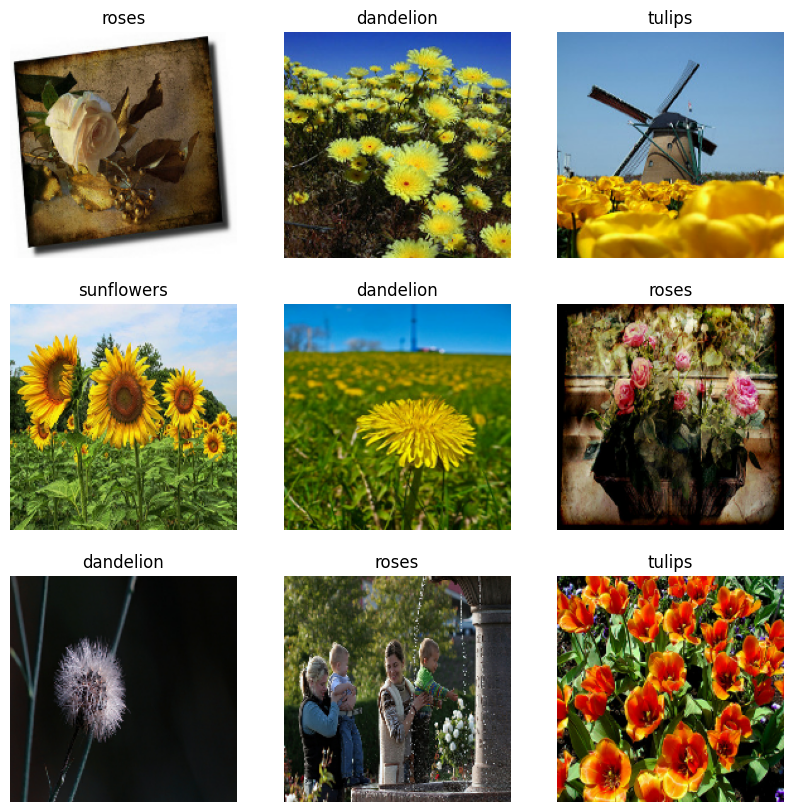

In [71]:
import matplotlib.pyplot as plt

plt.figure( figsize=(10,10) )

for images, labels in train_ds.take(1):         # labels is the numerical id for each flower class
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We can also manually iterate over the dataset and retrieve batches of images


In [72]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor with shape (32, 180, 180, 3).
It's a batch of 32 images of shape 180 x 180 x 3 where the last dim. refers to colour channel RGB.
The `label_batch` is a tensor of shape (32,) which are the labels of the 32 images.

These can be converted into `numpy.ndarray` by
`.numpy()`

# 5) Standardize the Data
RGB values are in [0,255] range - but not ideal for NN.
In general, we seek our input values **small**.
We should **standardize the data to [0,1]**.

Standardizing the data can be done through:
1. Using kera's rescaling and normalize all values through iteration.
2. Include it in the model definition for simplification.

In [73]:
# Method 1: Create a normalization layer with Kera's rescaling
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [74]:
# Normalize the dataset
normalized_ds = train_ds.map( lambda x, y: (normalization_layer(x),y) )
image_batch, labels_batch = next(iter(normalized_ds))

# Pixel values are now normalized
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


# 6) Configure the Dataset for Performance
Use buffered prefetching to yield data from disk without having I/O become blocking. There are two important methods when loading data:
1. `Dataset.cache` - keeps image in memory after they're loaded off disk during first epoch. Ensures dataset does not become a bottleneck during model training. If the dataset is too large for memory, you can use this method to create a performant on-disk cache.
2. `Dataset.prefetch` - overlaps data preprocessing and model excecution while training.

Refer to [tf.data API](https://www.tensorflow.org/guide/data_performance) for efficient data loading.



In [75]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 7) Training a Model
The **Sequential** model is appropriate for plain stack of layers where each layer has **exactly one input tensor and one output tensor**.



```
# Example of Sequential Model Use:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
y = model(x)
```



This Sequential model:

* `tf.keras.layers.Conv2D` - with a max pooling layer
* `tf.keras.layers.MaxPooling2D`- the max pooling layer in each conv2D
* `tf. keras.layers.Dense`- fully connected layer with 128 units on top of it activated by a ReLU activation function
* `tf.keras.layers.Dropout` - sets input units to 0 with a freq. of `rate` at each step during training time, which helps overfitting. Inputs not set to 0 are scalled up by 1/(1-`rate`).

Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.


In [81]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),   # (filters, kernel siz, activation function)
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. 

To view training and validation accuracy for each training epoch, pass the `metrics `argument to `Model.compile`.

**Compile the Model**

In [82]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

**Fit the Model**

In [88]:
results = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 143s 2s/step - loss: 0.7744 - accuracy: 0.7098 - val_loss: 0.9488 - val_accuracy: 0.6308
Epoch 2/3
92/92 [==============================] - 141s 2s/step - loss: 0.6099 - accuracy: 0.7650 - val_loss: 1.0693 - val_accuracy: 0.6076
Epoch 3/3
92/92 [==============================] - 142s 2s/step - loss: 0.4906 - accuracy: 0.8294 - val_loss: 1.3182 - val_accuracy: 0.6131


# 8) Visualizing Training Results
After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.

Accuracy: [0.7098092436790466, 0.7649863958358765, 0.8293596506118774]
Loss: [0.7098092436790466, 0.7649863958358765, 0.8293596506118774]
Val Accuracy: [0.7098092436790466, 0.7649863958358765, 0.8293596506118774]
Val Loss: [0.7098092436790466, 0.7649863958358765, 0.8293596506118774]


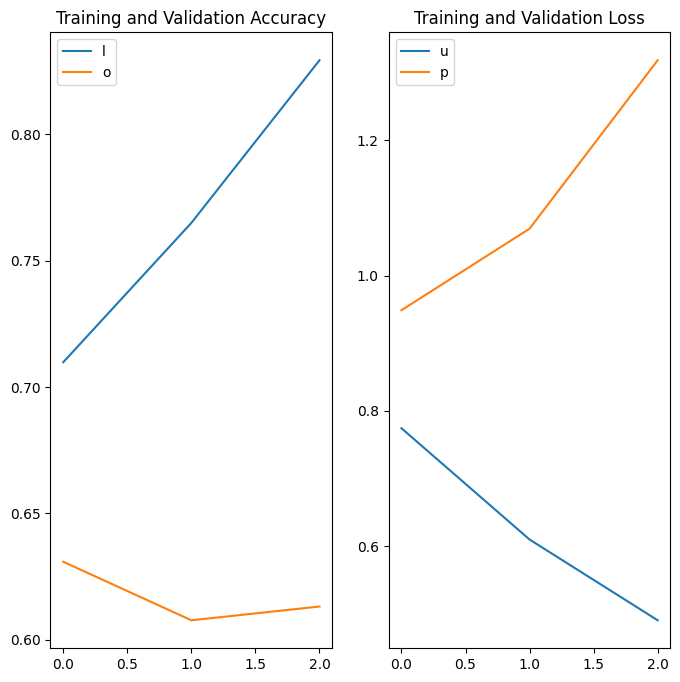

In [97]:
acc = results.history['accuracy']
loss = results.history['loss']

val_acc = results.history['val_accuracy']
val_loss = results.history['val_loss']

print("Accuracy:", acc)
print("Loss:", acc)
print("Val Accuracy:", acc)
print("Val Loss:", acc)

epochs_range = range(3)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)

plt.plot( epochs_range, acc, label = 'Training Accuracy' )
plt.plot( epochs_range, val_acc, label = 'Validation Accuracy' )
plt.legend('lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( epochs_range, loss, label = 'Training Loss')
plt.plot( epochs_range, val_loss, label = 'Validation Loss' )
plt.legend('upper right')
plt.title('Training and Validation Loss')

plt.show()

# 9) Data Augmentation
Overfitting occurs when training examples are too small.
Data augmentation takes the approach of generating additional training data from existing samples and using random transformations on them to expose the model to different aspects to the data.

We can use:
* `tf.keras.layers.RandomFlip`
* `tf.keras.layers.RandomRotation`
* `tf.keras.layers.RandomZoom`

In [98]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal",
        input_shape = (img_height,img_width,3)),

        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

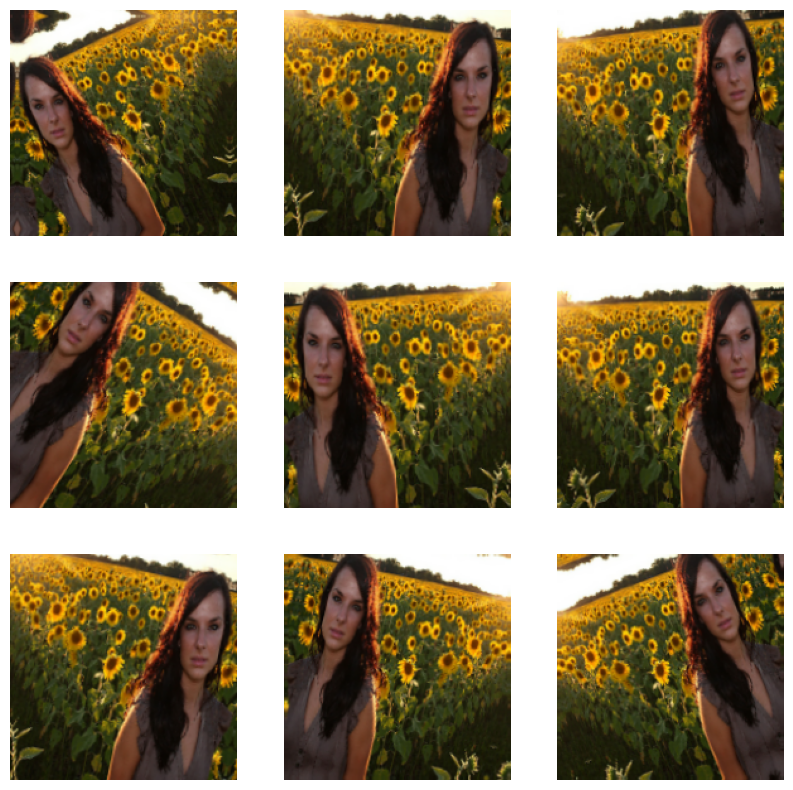

In [100]:
plt.figure( figsize=(10,10) )

for images, _ in train_ds.take(1):
  
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis("off")

# 10) Using the Model to Predict on New Data

1/1 [==============================] - 0s 35ms/step
This image most likely belongs to tulips with a 61.04 percent confidence.


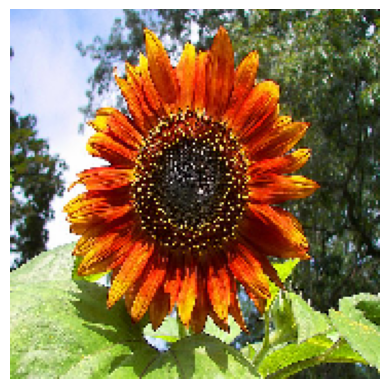

In [105]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
plt.imshow(img)
plt.axis('Off')
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# Using Tensorflow Datasets

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))